In [1]:
import os, sys
import warnings
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
from tqdm import tqdm
import decoupler as dc

sys.path.append('../src')
import scp_infer
import matplotlib.pyplot as plt
#matplotlib.use('TkAgg')
%matplotlib inline

/home/pi226/.conda/envs/pytorch-jax-3.11.13/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 10.0.1. Please consider upgrading.
  warnings.warn(
Detecting 4 CUDA device(s).
2025-07-16 11:12:58 | [INFO] Created a temporary directory at /tmp/tmp2zsei8wr
2025-07-16 11:12:58 | [INFO] Writing /tmp/tmp2zsei8wr/_remote_module_non_scriptable.py


### Running GRN Inference on experimental scPerturbSeq Data

Structured into the following sections:
1. Data Import and Preprocessing
2. GNR inference steps using the selected Algorithms
3. Visualisation and Evaluation inferred GRNs

### 1. Data Import

#### a. Import experimental data

In [2]:
data_folder = './data/experimental'
output_folder = './data/experimental/output'
plot_folder = './data/experimental/plots/'
filename_sub = 'Perturb-CITE-Seq-Co-culture-all_genes-sub.h5ad'

Here we import an experimental scPerturb-Seq dataset in the form of a scanpy AnnData file (`.h5ad`). We presume that the file has already been pre-processed under a typical sc-RNAseq workflow with the specific experimental context in mind. In particular we start here with a file that has:

1. Cells filtered for a single cell type and experimental context
3. Cells filtered for high gene counts (e.g > 500) and quality metrics such as MT-genes
2. Genes filtered for high read counts (e.g. >100)
4. optionally - genes selected for HV

In [3]:
#adata = sc.read_h5ad(os.path.join(data_folder, filename))
adata = sc.read_h5ad(os.path.join(data_folder, filename_sub))

#### b. Read annotation of cells/perturbations

The perturbation annotation of each cell needs to be supplied as a column in the `.obs` dataframe of the AnnData object. Perturbed cells should feature a string in this column which begins with the name of the targeted gene (as listed in the `var_names` annotation) followed by an underscore. Cells with non-targeting gRNA should all have an identical label identifying them as such, followed by an underscore.

In [4]:
adata.obs.head()[:2]

,NAME,library_preparation_protocol,condition,MOI,sgRNA,UMI_count,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,perturbation,non-targeting,multiplet,control,nan,gene_perturbation_mask
NAME,,,,,,,,,,,,,,,,,
CELL_145218,CELL_145218,10X 3' v3 sequencing,Co-culture,1,SLC26A2_3,21751.0,4464,4459,20603.138672,99.434425,0.482618,SLC26A2,False,False,False,False,True
CELL_145219,CELL_145219,10X 3' v3 sequencing,Co-culture,1,CCND2_1,14290.0,3628,3628,17846.359375,94.132828,0.527462,CCND2,False,False,False,False,False


In [5]:
print(adata.obs["sgRNA"].value_counts().keys().to_list()[:10])

['IFNGR2_2', 'JAK2_1', 'JAK2_3', 'JAK1_1', 'STAT1_3', 'IFNGR2_3', 'JAK1_2', 'HLA-DRB5_2', 'NO_SITE_47', 'IFNGR2_1']


In this case the labels are stored in the column `sgRNA` and non-targeting gRNAs are labelled as `NO_SITE`, since the function we use separates strings at the first underscore, we pass it the label of the column `sgRNA` and `NO` as a label marking control cells, giving us 43121 perturbed cells and 3291 control cells.

When using a differrent dataset, please verify that all cells are correctly assigned.

In [6]:
scp_infer.adata.get_perturb_labels(adata, perturbation_entry="sgRNA", non_targeting_label='NO')
scp_infer.adata.convert_perturb_labels_to_onehot(adata)

# remove un-assigned cells
adata = adata[adata.obs['perturbation'] != 'nan'].copy()

Non-targeting: 3291
Multiplet: 0
Control: 0
Nan: 0
Normal pert.: 43121
Filtered 7748 un-identifiable perturbations:  35373 filtered perturbations


/home/pi226/documents/inference-pkg/tutorials/../src/scp_infer/adata/filter_adata.py:223: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a Series, Index, or np.array before operating instead.


#### c. Perform pre-processing and feature selection

Preprocessing: normalisation of secuencing depth and shifted-log transformation of UMI counts

In [7]:
# Saving count data
adata.layers["counts"] = adata.X.copy()
# Normalizing to median total counts
sc.pp.normalize_total(adata,key_added='norm_factors')
# Logarithmize the data
sc.pp.log1p(adata)

feature selection can be done by the following options (WIP):

0. manual gene selection
1. top-N HV genes
2. all pert. genes
3. top-N target genes - based on DE
4. all targets that show DE
5. all targets + all genes that show DE

As there are 221 target genes in this PerturbSeq Dataset, which DCDI and Bicycle do not scale to, we here choose (4) top-N target genes based on DE, with N=40

In [8]:
genes_to_use = scp_infer.adata.filter_genes(adata, option=3, N_genes = 40)

Found 221 target genes in the data.
perturbed_genes:  Index(['ACSL3', 'ACTA2', 'AEBP1', 'AGA', 'AHCY', 'AHNAK', 'APOE', 'ARMC6',
       'ATP1A1', 'ATP1B1',
       ...
       'TXNDC17', 'UBA52', 'UBC', 'UBL5', 'UCN2', 'UQCRFS1', 'UQCRH', 'VAT1',
       'VDAC2', 'WBP2'],
      dtype='object', length=221)
reference: non-targeting
group_names: ('A2M', 'ACSL3', 'ACTA2', 'AEBP1', 'AGA', 'AHCY', 'AHNAK', 'APOC2', 'APOD', 'APOE', 'ARMC6', 'ATP1A1', 'ATP1B1', 'ATP5MD', 'B2M', 'BOLA2', 'BOLA2B', 'BZW2', 'C19orf48', 'C1QBP', 'C6orf226', 'CCND1', 'CCND2', 'CCR10', 'CCT3', 'CCT6A', 'CD151', 'CD274', 'CD44', 'CD47', 'CD58', 'CD59', 'CD63', 'CDC123', 'CDH19', 'CDK4', 'CDK6', 'CDKN1A', 'CDKN2A', 'CDKN2B', 'CGAS', 'CHCHD2', 'CITED1', 'CKS1B', 'CMSS1', 'CORO1A', 'CSPG4', 'CST3', 'CTPS1', 'CTSA', 'CTSB', 'CTSD', 'CTSL', 'CTSO', 'CXCR4', 'CYP27A1', 'DAG1', 'DDR1', 'DDX17', 'DDX39A', 'DLL3', 'DNAJC9', 'DNMT1', 'E2F1', 'EEA1', 'EEF1G', 'EIF2S3', 'EIF3K', 'EIF4A1', 'EMP1', 'ENPP1', 'EVA1A', 'FARSA', 'FBL', '

221it [00:02, 85.85it/s]

Found 40 target genes based on DE-score.


In [9]:
# Filter the adata object to only include only the selected features
adata = adata[:, genes_to_use].copy() 
print(f'Using {len(genes_to_use)} genes for inference: {genes_to_use}')
print('Anndata shape:', adata.shape)

# remove cells where the target gene was filtered out
to_keep = pd.Series(adata.obs['perturbation'].isin(genes_to_use)) | pd.Series(adata.obs['perturbation'] == 'non-targeting')
adata = adata[to_keep].copy()
print('Anndata shape (after filtering):', adata.shape)

Using 40 genes for inference: ['STAT1', 'JAK1', 'CTSD', 'TGFB1', 'VDAC2', 'IFNGR1', 'CTSB', 'LRPAP1', 'CTSA', 'CTSL', 'GRN', 'SDCBP', 'HSPA1A', 'CMSS1', 'SCARB2', 'SP100', 'SERPINE2', 'LAMP2', 'NONO', 'VAT1', 'HLA-E', 'CD151', 'B2M', 'CD63', 'CDK4', 'NPC2', 'FKBP4', 'IDH2', 'SEC11C', 'SET', 'CGAS', 'ATP5MD', 'STOM', 'C1QBP', 'ATP1B1', 'STX7', 'BZW2', 'WBP2', 'ACSL3', 'CHCHD2']
Anndata shape: (46412, 40)
Anndata shape (after filtering): (11517, 40)


### 2. GRN Inference

In [10]:
implementation_dict = {
    'GRNBoost2': scp_infer.inference.grnboost2.GRNBoost2Imp,
    'GIES': scp_infer.inference.gies.GIESImp,
    'DCDI': scp_infer.inference.dcdi.DCDIImp,
    'Bicycle': scp_infer.inference.bicycle.BicycleImp,
    'AVICI': scp_infer.inference.avici.AVICI_Imp
}

__GRNBoost2, GIES, AVICI:__

In [12]:
for algorithm in ['GRNBoost2','GIES','AVICI']:
    out_dir = os.path.join(output_folder, algorithm)
    os.makedirs(out_dir, exist_ok=True)
    # run the inference
    imp_instance = implementation_dict[algorithm](adata[::10], output_dir=out_dir, verbose=True)
    imp_instance.convert_data()
    ad_matrix,runtime = imp_instance.infer(plot=False)
    # apply a threshold to the inferred adjacency matrix
    if algorithm == 'GRNBoost2':
        ad_matrix = (ad_matrix > ad_matrix.max()*0.5).astype(int)
    # save the inferred adjacency matrix
    np.savetxt(os.path.join(out_dir, algorithm+'_adjacency_matrix.txt'), ad_matrix)


Running GRNBoost2
preparing dask client


2025-07-16 10:54:09 | [INFO] To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2025-07-16 10:54:09 | [INFO] State start
2025-07-16 10:54:09 | [INFO]   Scheduler at:     tcp://127.0.0.1:37503
2025-07-16 10:54:09 | [INFO]   dashboard at:  http://127.0.0.1:8787/status
2025-07-16 10:54:09 | [INFO] Registering Worker plugin shuffle
2025-07-16 10:54:09 | [INFO]         Start Nanny at: 'tcp://127.0.0.1:36421'
2025-07-16 10:54:09 | [INFO]         Start Nanny at: 'tcp://127.0.0.1:39025'
2025-07-16 10:54:09 | [INFO]         Start Nanny at: 'tcp://127.0.0.1:40937'
2025-07-16 10:54:09 | [INFO]         Start Nanny at: 'tcp://127.0.0.1:46597'
2025-07-16 10:54:09 | [INFO]         Start Nanny at: 'tcp://127.0.0.1:40857'
2025-07-16 10:54:09 | [INFO]         Start Nanny at: 'tcp://127.0.0.1:41595'
2025-07-16 10:54:09 | [INFO]         Start Nanny at: 'tcp://127.0.0.1:34031'
2025-07-16 10:54:09 | [INFO]         Start Nanny at: 'tcp:/

parsing input
creating dask graph
16 partitions
computing dask graph


/home/pi226/.conda/envs/pytorch-jax-3.11.13/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 10.0.1. Please consider upgrading.
  warnings.warn(
/home/pi226/.conda/envs/pytorch-jax-3.11.13/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 10.0.1. Please consider upgrading.
  warnings.warn(
/home/pi226/.conda/envs/pytorch-jax-3.11.13/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 10.0.1. Please consider upgrading.
  warnings.warn(
/home/pi226/.conda/envs/pytorch-jax-3.11.13/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 10.0.1. Please consider upgrading.
  war

shutting down client and local cluster


2025-07-16 10:54:18 | [INFO] Remove worker <WorkerState 'tcp://127.0.0.1:40799', name: 14, status: closing, memory: 0, processing: 0> (stimulus_id='handle-worker-cleanup-1752656058.172037')
2025-07-16 10:54:18 | [INFO] Received 'close-stream' from tcp://127.0.0.1:36670; closing.
2025-07-16 10:54:18 | [INFO] Remove worker <WorkerState 'tcp://127.0.0.1:45797', name: 15, status: closing, memory: 0, processing: 0> (stimulus_id='handle-worker-cleanup-1752656058.177489')
2025-07-16 10:54:18 | [INFO] Lost all workers
2025-07-16 10:54:18 | [INFO] Batched Comm Closed <TCP (closed) Scheduler connection to worker local=tcp://127.0.0.1:37503 remote=tcp://127.0.0.1:36670>
Traceback (most recent call last):
  File "/home/pi226/.conda/envs/pytorch-jax-3.11.13/lib/python3.11/site-packages/distributed/batched.py", line 115, in _background_send
    nbytes = yield coro
             ^^^^^^^^^^
  File "/home/pi226/.conda/envs/pytorch-jax-3.11.13/lib/python3.11/site-packages/tornado/gen.py", line 769, in ru

finished
GRNBoost2 fnished
Time taken:  12.289876222610474
network shape:  (1484, 3)
Saving output
Output saved
Running GIES
GIES fnished
Time taken:  274.86901354789734
estimate shape:  (40, 40)
Saving output
Output saved
Using default cache_path: `/home/pi226/documents/inference-pkg/tutorials/cache`


INFO:2025-07-16 10:59:26,274:jax._src.xla_bridge:752: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
2025-07-16 10:59:26 | [INFO] Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
2025-07-16 10:59:26 | [WARNING] An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


AVICI data conversion done
Running AVICI
AVICI fnished
Time taken:  3.6212222576141357
Memory usage:  23357885
Saving output
Output saved


**DCDI**: For DCDI a few choices regarding model configuration as well as hyerparameter choice have to be made. Here we offer some "toy" parameters to verify that the model runs, for ideal performance these should be adjust adjusted - especially the train iterations should be increased and the learning rate decreased.

Parameters which we have found to work well are:

    - train_iterations = 150000
    - learning_rate = 1e-2
    - reg_coeff = 1e-1

The model train and test likelihoods, as well as it's learned edge weights can be observed during training in `learning-curves.png` and `w_adj_gumbel.png` respectively.

In [ ]:
algorithm = 'DCDI-Drop'
out_dir = os.path.join(output_folder, algorithm)
os.makedirs(out_dir, exist_ok=True)
imp_instance = scp_infer.inference.DCDIImp(
    adata[::10], 
    output_dir=out_dir, 
    verbose=False,
    train_iterations = 30000,
    learning_rate = 1e-2,
    reg_coeff = 1.0,
    use_GPU=True,
    weighted_adjacency=True,
    model = 'DCDI-Drop',
)

imp_instance.convert_data()
ad_matrix, runtime = imp_instance.infer(plot=True)
print(f"Inferred GRN for {algorithm} with {np.sum(ad_matrix > 0.5)} edges.")
np.savetxt(os.path.join(out_dir, algorithm+'_weighted_adjacency_matrix.txt'), ad_matrix)
np.savetxt(os.path.join(out_dir, algorithm+'_adjacency_matrix.txt'), (ad_matrix > 0.5).astype(int))

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
num_regimes: 41
train_data.adjacency.device: cuda:0


/home/pi226/documents/inference-pkg/tutorials/../src/scp_infer/thirdparty/dcdi_local/prox.py:43: UserWarning: This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1485.)


Iteration: 0
Iteration: 100


__Bicycle__:

In [13]:
algorithm = 'Bicycle'
out_dir = os.path.join(output_folder, algorithm)
os.makedirs(out_dir, exist_ok=True)
adata_raw = adata.copy()
adata_raw.X = adata_raw.layers["counts"].copy()  # Use raw counts for Bicycle
imp_instance = scp_infer.inference.bicycle.BicycleImp(
    adata_raw[::10], 
    output_dir=out_dir, 
    verbose=True,
    n_epochs = 10000,
    n_epochs_pretrain_latents = 5000,
    scale_lyapunov = 0.1)
imp_instance.convert_data()
ad_matrix, runtime = imp_instance.infer(plot=True)
print(f"Inferred GRN for {algorithm} with {np.sum(ad_matrix > 0.5)} edges.")

# apply a threshold to the Bicycle output regulation matrix
algorithm = 'Bicycle'
out_dir = os.path.join(output_folder, algorithm)
ad_matrix = np.load(os.path.join(out_dir, 'bicycle_adjacency.npy'))
np.savetxt(os.path.join(out_dir, algorithm+'_weighted_adjacency_matrix.txt'), ad_matrix)
ad_matrix_boolean = (np.abs(ad_matrix) > 0.1).astype(int)
np.savetxt(os.path.join(out_dir, algorithm+'_adjacency_matrix.txt'), ad_matrix_boolean)
print(f"Inferred GRN for {algorithm} with {np.sum(ad_matrix_boolean)} edges.")

/home/pi226/documents/inference-pkg/tutorials/../src/scp_infer/inference/bicycle/bicycle_imp.py:206: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
2025-07-16 13:16:25 | [INFO] GPU available: True (cuda), used: True
2025-07-16 13:16:25 | [INFO] TPU available: False, using: 0 TPU cores
2025-07-16 13:16:25 | [INFO] IPU available: False, using: 0 IPUs
2025-07-16 13:16:25 | [INFO] HPU available: False, using: 0 HPUs
2025-07-16 13:16:25 | [INFO] GPU available: True (cuda), used: True
2025-07-16 13:16:25 | [INFO] TPU available: False, using: 0 TPU cores
2025-07-16 13:16:25 | [INFO] IPU available: False, using: 0 IPUs
2025-07-16 13:16:25 | [INFO] HPU available: False, using: 0 HPUs
/home/pi226/.conda/envs/pytorch-jax-3.11.13/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:617: UserWarning: Checkpoint directory data/experimental/output/Bicycle/models/DictLogger/0/checkpoints exists and is not empty.
2025-07-16 1

Number of training samples: 818
Number of validation samples: 147
Number of test samples: 84
file dir:  IFN_Epochs_100_Pretrainepochs_100_Encoder_False_adam_1024_1_1.0_0_False_0.001_1.0_1.0_0.0_0.1
Files do not exist, fitting model...
Deleting dirs
Creating dirs
Running Bicycle
Training model
PRETRAINING LATENTS!
Using optimizer_kwargs: {}


┏━━━┳━━━━━━┳━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name ┃ Type     ┃ Params ┃
┡━━━╇━━━━━━╇━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ pos  │ Softplus │      0 │
└───┴──────┴──────────┴────────┘

Trainable params: 132 K                                                                                            
Non-trainable params: 1.6 K                                                                                        
Total params: 134 K                                                                                                
Total estimated model params size (MB): 0

Output()

/home/pi226/.conda/envs/pytorch-jax-3.11.13/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
/home/pi226/.conda/envs/pytorch-jax-3.11.13/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
2025-07-16 13:17:21 | [INFO] `Trainer.fit` stopped: `max_epochs=100` reached.


Saving training stats to 
data/experimental/output/Bicycle/models/IFN_Epochs_100_Pretrainepochs_100_Encoder_False_adam_1024_1_1.0_0_False_0.0
01_1.0_1.0_0.0_0.1/report.yaml...

/home/pi226/.conda/envs/pytorch-jax-3.11.13/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:617: UserWarning: Checkpoint directory data/experimental/output/Bicycle/models/IFN_Epochs_100_Pretrainepochs_100_Encoder_False_adam_1024_1_1.0_0_False_0.001_1.0_1.0_0.0_0.1 exists and is not empty.
2025-07-16 13:17:21 | [INFO] LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Using optimizer_kwargs: {}


┏━━━┳━━━━━━┳━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name ┃ Type     ┃ Params ┃
┡━━━╇━━━━━━╇━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ pos  │ Softplus │      0 │
└───┴──────┴──────────┴────────┘

Trainable params: 132 K                                                                                            
Non-trainable params: 1.6 K                                                                                        
Total params: 134 K                                                                                                
Total estimated model params size (MB): 0

Output()

/home/pi226/.conda/envs/pytorch-jax-3.11.13/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
/home/pi226/.conda/envs/pytorch-jax-3.11.13/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
2025-07-16 13:18:16 | [INFO] `Trainer.fit` stopped: `max_epochs=100` reached.


Saving training stats to 
data/experimental/output/Bicycle/models/IFN_Epochs_100_Pretrainepochs_100_Encoder_False_adam_1024_1_1.0_0_False_0.0
01_1.0_1.0_0.0_0.1/report.yaml...

Training took 111.31 seconds
Bicycle finished
Time taken:  112.70958113670349
Memory usage:  70010880
Saving output
Output saved
Inferred GRN for Bicycle with 0 edges.
Inferred GRN for Bicycle with 14 edges.


### 3. Evaluate Inferred GRNs

#### a. Plot graphs - or selected portions

Inferred GRN for GRNBoost2 with shape (40, 40), min 0.0, max 1.0
Inferred GRN for GIES with shape (40, 40), min 0.0, max 1.0
Inferred GRN for DCDI-Drop with shape (40, 40), min 0.0, max 1.0
Inferred GRN for Bicycle with shape (40, 40), min 0.0, max 1.0
Inferred GRN for AVICI with shape (40, 40), min 0.0, max 1.0


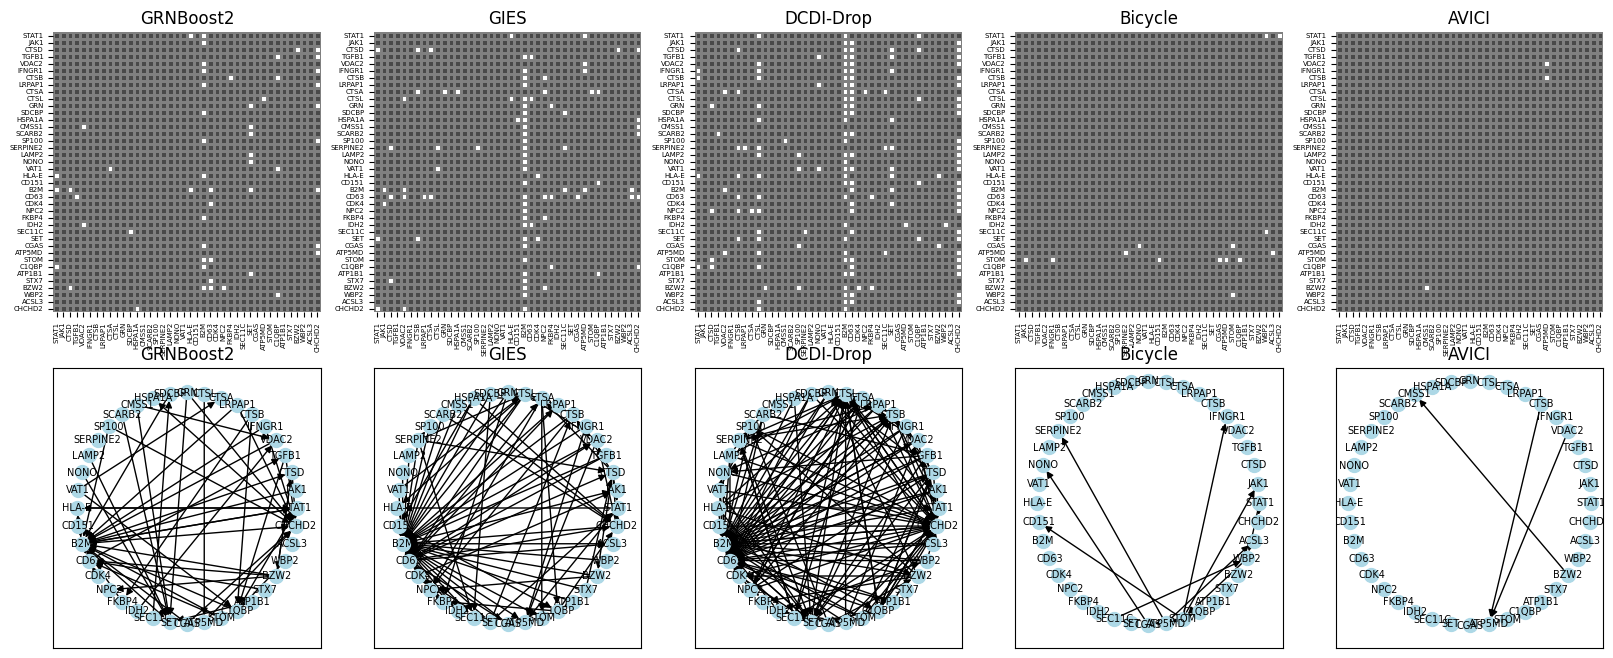

In [24]:
# A. Draw the full inferred GRNs

algorithms = ['GRNBoost2', 'GIES', 'DCDI-Drop', 'Bicycle', 'AVICI']
gene_names = adata.var_names.to_list()

fig, axes = plt.subplots(2,len(algorithms), figsize=((4 * (len(algorithms))), 8))

# plot the inferred GRN graphs
for i, algorithm in enumerate(algorithms):
    out_dir = os.path.join(output_folder, algorithm)
    GRN = np.loadtxt(os.path.join(out_dir, algorithm+'_adjacency_matrix.txt'))
    print(f"Inferred GRN for {algorithm} with shape {GRN.shape}, min {GRN.min()}, max {GRN.max()}")
    graph = nx.from_numpy_array(GRN, create_using=nx.DiGraph, nodelist=gene_names)
    axes[0,i].set_title(algorithm)
    #axes[0,i].imshow(GRN, cmap='Blues', vmin=0, vmax=1)
    sns.heatmap(GRN, ax=axes[0,i], cbar=False, linewidths = 2, linecolor = 'gray', cmap='gray',vmin=-0.4,vmax=1, xticklabels=gene_names, yticklabels=gene_names)
    axes[0,i].set_xticklabels(gene_names, rotation=90, fontsize=5)
    axes[0,i].set_yticklabels(gene_names, rotation=0, fontsize=5)
    nx.draw_networkx(graph, pos=nx.circular_layout(graph), ax=axes[1,i], with_labels=True, node_size=100, font_size=7, node_color='lightblue', font_color='black')
    axes[1,i].set_title(algorithm)

Drawing subgraphs for nodes: ['STAT1', 'JAK1', 'TGFB1']


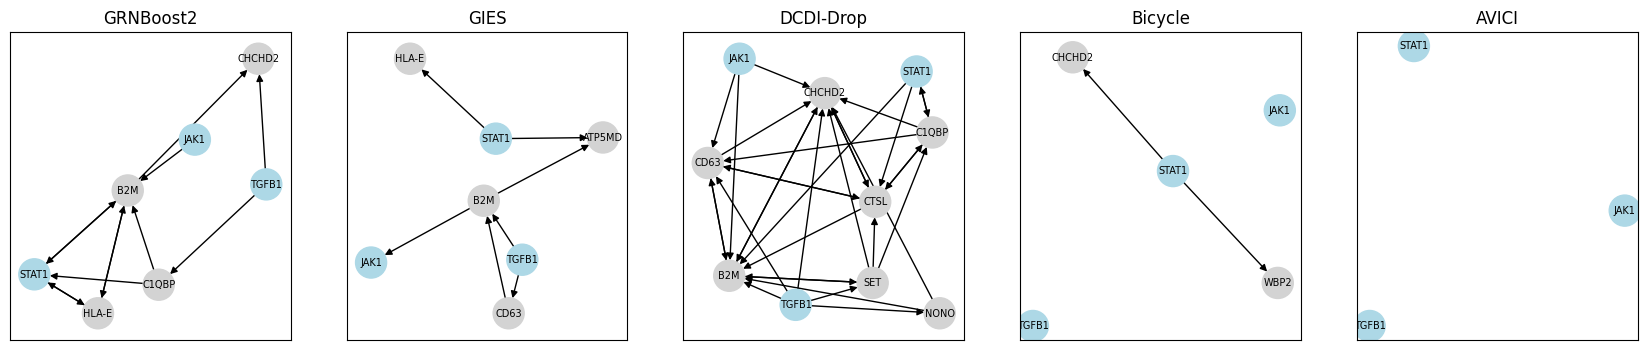

In [25]:
# B. Draw subgraphs for specified nodes
node_list = ['STAT1', 'JAK1', 'TGFB1']
print(f"Drawing subgraphs for nodes: {node_list}")

def get_subgraph(graph, node_list):
    # if node is not in the graph, it will be ignored
    node_list = [node for node in node_list if node in graph.nodes()]
    neighbors = set().union(*[set(graph.neighbors(node)) for node in node_list])
    subgraph_nodes = set(node_list).union(neighbors)
    return graph.subgraph(subgraph_nodes)

def plot_subgraph(graph, node_list, ax):
    subgraph = get_subgraph(graph, node_list)
    color_map = {node: 'lightblue' if node in node_list else 'lightgray' for node in subgraph.nodes()}
    pos = nx.spring_layout(subgraph, seed=42, k=0.8)
    nx.draw_networkx(subgraph, pos=pos, ax=ax, with_labels=True, node_size=500, font_size=7, node_color=list(color_map.values()), font_color='black')

fig, axes = plt.subplots(1, len(algorithms), figsize=((4 * len(algorithms))+1, 4))
for i, algorithm in enumerate(algorithms):
    # 1. Load the inferred GRN
    out_dir = os.path.join(output_folder, algorithm)
    GRN = np.loadtxt(os.path.join(out_dir, algorithm+'_adjacency_matrix.txt'))
    graph = nx.from_numpy_array(GRN, create_using=nx.DiGraph, nodelist=gene_names)
    # 2. Get the subgraph for the specified nodes
    subgraph = get_subgraph(graph, node_list)
    # 3. Draw the subgraph
    plot_subgraph(graph, node_list, axes[i])
    axes[i].set_title(algorithm)

#### b. Compare inferred GRNs to annotated GRN as GT

Here we make use of the CollecTRI annotated GRN of Homo Sapiens, but a different, possibly more cell-type- or context-specific, GRN may be used in it's place.

TFs: 		 ['STAT1', 'NONO']
n_TFs: 		 2
n_targets: 	 7


Text(0.5, 1.0, 'Collectri GRN - full graph')

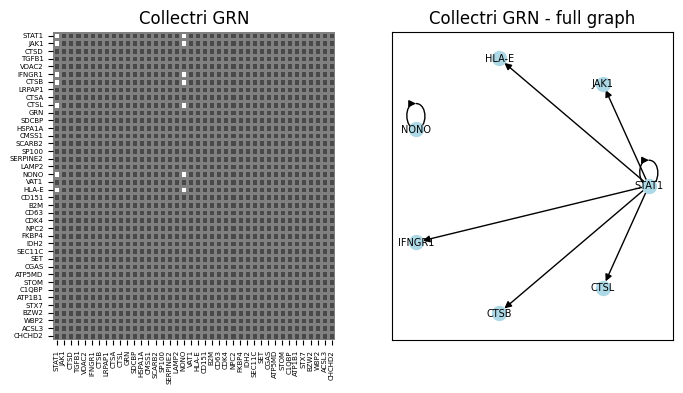

In [26]:
# import collectri grn, take the relevant subnetwork and transform it to an adjacency matrix
collectri_grn = dc.op.collectri(organism='human', remove_complexes=False)
collectri_grn = scp_infer.eval.colltectri_subgraph(adata.var_names,collectri_grn)

# how many TFs are there in the 40 genes?
all_TFs = collectri_grn['source'].unique()
TFs_sub = [gene for gene in adata.var_names if gene in all_TFs]
print('TFs: \t\t',TFs_sub)
print('n_TFs: \t\t',     len(TFs_sub))
print('n_targets: \t', len(collectri_grn['target'].unique()))

# transform the collectri graph to an adjacency matrix
collectri_mat = np.zeros((40,40))
genes = adata.var_names
for i in range(40):
    for j in range(40):
        if genes[i] in collectri_grn['source'].unique():
            if genes [j] in collectri_grn['target'].unique():
                collectri_mat[j,i] = 1

# plot the collectri graph and the adjacency matrix
fig,axes = plt.subplots(1,2,figsize=(8,4))
# adjacency matrix of the collectri graph
axes[0].set_title('Collectri GRN')
sns.heatmap(collectri_mat, ax=axes[0], cbar=False, linewidths = 2, linecolor = 'gray', cmap='gray',vmin=-0.4,vmax=1, xticklabels=genes, yticklabels=genes)
axes[0].set_xticklabels(genes, rotation=90, fontsize=5)
axes[0].set_yticklabels(genes, rotation=0, fontsize=5)
# complete Collectri graph
collectri_graph = nx.from_pandas_edgelist(collectri_grn, source='source', target='target', create_using=nx.DiGraph)
nx.draw_networkx(collectri_graph, pos=nx.circular_layout(collectri_graph), ax=axes[1], with_labels=True, node_size=100, font_size=7, node_color='lightblue', font_color='black')
axes[1].set_title('Collectri GRN - full graph')

Algorithm: GRNBoost2, Precision: 0.02, Recall: 0.07
Algorithm: GIES, Precision: 0.00, Recall: 0.00
Algorithm: DCDI-Drop, Precision: 0.02, Recall: 0.21
Algorithm: Bicycle, Precision: 0.00, Recall: 0.00
Algorithm: AVICI, Precision: 0.00, Recall: 0.00


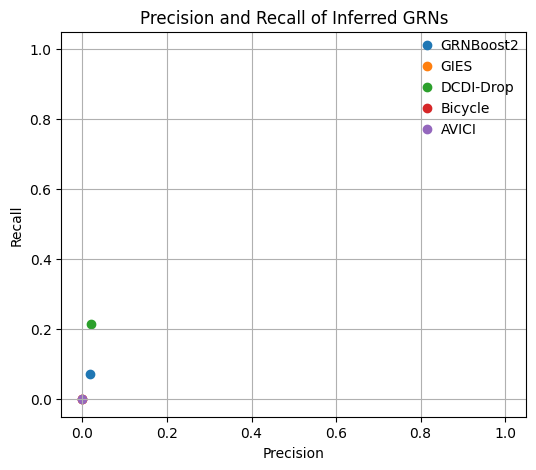

In [28]:
# plot precision and recall of the inferred GRNs
precision = []
recall = []
for i, algorithm in enumerate(algorithms):
    out_dir = os.path.join(output_folder, algorithm)
    adj_mat = np.loadtxt(os.path.join(out_dir, algorithm+'_adjacency_matrix.txt'))
    
    # Calculate precision and recall
    precision.append(scp_infer.eval.precision(collectri_mat, adj_mat))
    recall.append(scp_infer.eval.recall(collectri_mat, adj_mat))
    print(f'Algorithm: {algorithm}, Precision: {precision[i]:.2f}, Recall: {recall[i]:.2f}')

# Plot precision and recall
fig, axes = plt.subplots(1, 1, figsize=(6,5))
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Precision and Recall of Inferred GRNs')
for i, algorithm in enumerate(algorithms):
    axes.scatter(precision[i], recall[i], label=algorithm)
axes.legend()
axes.set_xlim(-0.05, 1.05)
axes.set_ylim(-0.05, 1.05)
axes.grid(True)
axes.legend()
plt.show()

In [29]:
# save CollecTRI adjacency matrix
out_dir = os.path.join(output_folder, algorithm)
os.makedirs(out_dir, exist_ok=True)
np.savetxt(os.path.join(out_dir, 'CollecTRI_adjacency_matrix.txt'), collectri_mat)

#### c. Compare inferred GRNs to DE of genes under perturbations

In [30]:
# TP/FP tests

# exclude low-quality genes (mean expression)?
# get the pvalues
p_values = scp_infer.utils.get_DE_expression_matrix(adata, score='pval').to_numpy()

rejected(naive):  83
rejected:  62
pvals_corrected 0.05:  60
pvals_corrected 0.1:  62
n_edges:  22


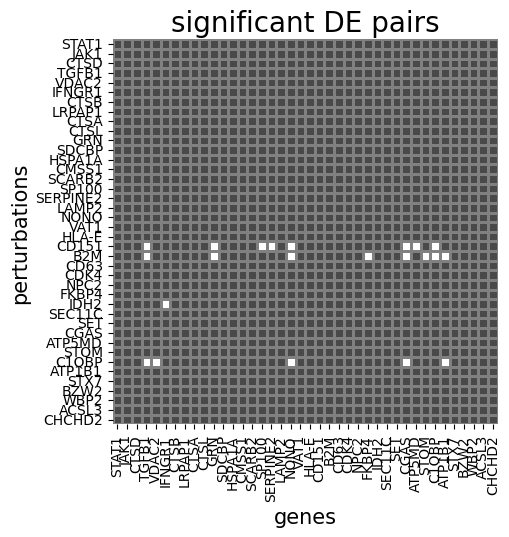

In [31]:
# perform multiple testing adjustment
from statsmodels.stats.multitest import multipletests
# Flatten the p-value matrix
pvals_flat = p_values.flatten()
print("rejected(naive): ",np.sum(pvals_flat<0.05))
# Apply FDR-BH correction
rejected, pvals_corrected, _, _ = multipletests(pvals_flat, alpha=0.1, method='fdr_bh')
# Reshape results to original shape
pvals_corrected_2d = pvals_corrected.reshape(p_values.shape)

print("rejected: ",np.sum(rejected))
print("pvals_corrected 0.05: ",np.sum(pvals_corrected<0.05))
print("pvals_corrected 0.1: ",np.sum(pvals_corrected<0.1))

# get matrix if p_values is below the threshold
threshold = 0.1
significant_pairs = (pvals_corrected_2d < threshold).astype(int)
# remove diagonal
np.fill_diagonal(significant_pairs, 0)
# remove-low-exp genes
#mask_mat = [large_mean for i in range(40)]
#significant_pairs = significant_pairs*mask_mat



# plot the significant pairs
print('n_edges: ',np.sum(significant_pairs))

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
filename = plot_folder + 'DE_edges_pertGT_.pdf'
scp_infer.utils.plot.plot_adjacency_matrix(significant_pairs,adata.var_names, ax, 'significant DE pairs', xlabel = 'genes', ylabel = 'perturbations', filename = filename)

In [32]:
from matplotlib.patches import Patch

model_names = [
    'GRNBoost2',
    'GIES',
    'DCDI-Drop',
    'Bicycle',
    'AVICI',
]
model_labels = [
    'GRNBoost2',
    'GIES',
    'DCDI-Drop',
    'Bicycle',
    'AVICI',
]
Method_labels_all = model_labels+ ['CollecTRI']

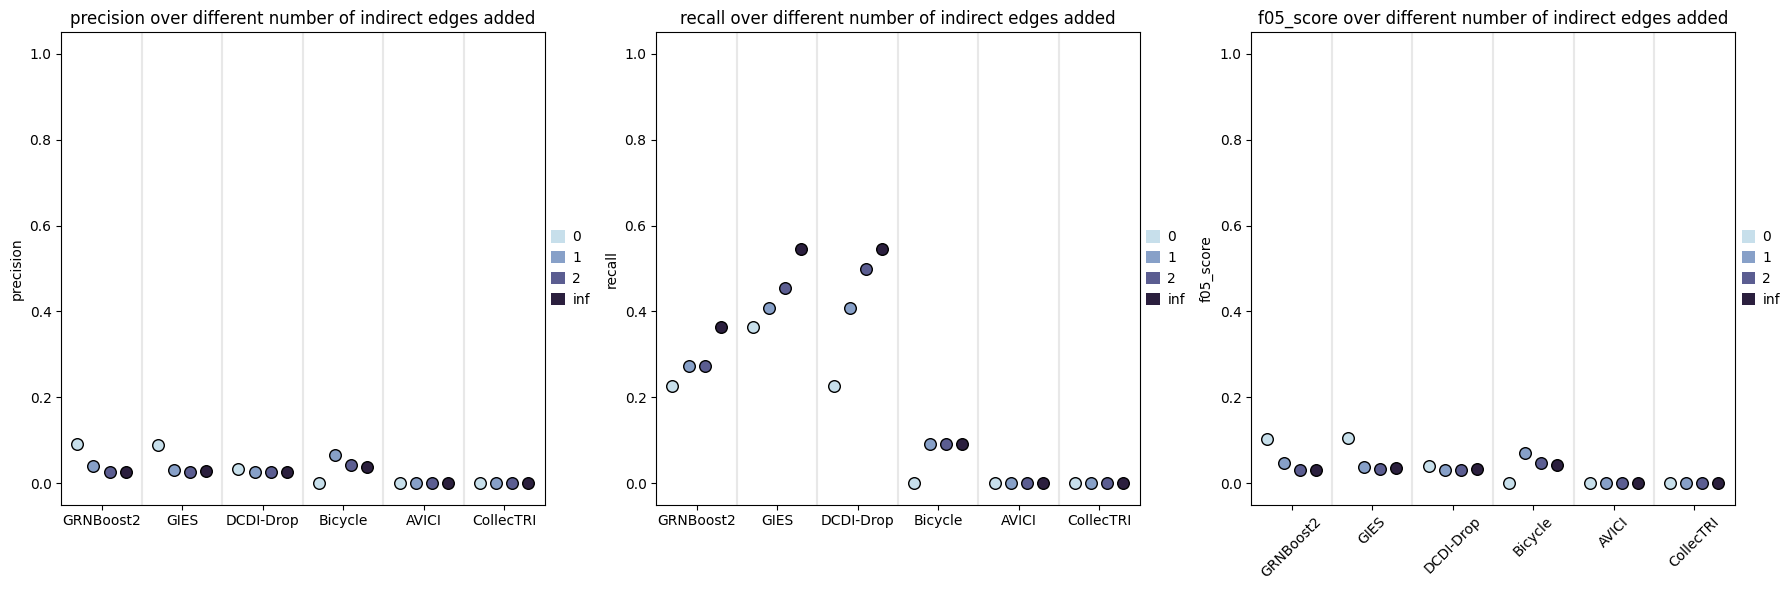

In [33]:
def plot_score_over_indirect_edges(model_names, score, significant_pairs, n_indirect_vals, ylabel, title, filename=None, verbose=False, ax = None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    else:
        fig = ax.get_figure()
    colors = sns.color_palette("ch:s=.25,rot=-.25", n_colors = len(n_indirect_vals))
    n_models = len(model_names)
    for j,n_indirect in enumerate(n_indirect_vals):
        values_all = []
        for i,model in enumerate(model_names):
            adj_mat = np.loadtxt(os.path.join(output_folder, model, model+'_adjacency_matrix.txt'))
            #if transpose[model]: adj_mats = [mat.T for mat in adj_mats]
            values_model = [scp_infer.utils.get_scores(adj_mat.T,significant_pairs).loc[n_indirect][score]]
            if verbose: print(model,' - ',n_indirect,': \t',values_model)
            values_all.append(values_model)
        
        offset = (-0.3 + j*0.6/3)
        
        #ax.boxplot(values_all, notch=False, boxprops=boxprops, whiskerprops=whiskerprops,capprops=capprops, 
        #           flierprops=flierprops, medianprops=medianprops,showmeans=False,patch_artist=True,
        #           positions = np.arange(n_models)+offset+1,widths=0.2)
        ax.scatter(np.arange(n_models)+offset+1, values_all, marker='o', linestyle='None', color=colors[j], label=str(n_indirect), edgecolors="black", s=70)

    #plt.vlines(np.arange(len(values_all))+0.5,0.1,1.0, color='grey',linestyle='dotted')
    ax.set_xticks(np.arange(len(model_names))+1)
    ax.set_xticklabels(model_names)
    plt.xticks(rotation=45)
    ax.vlines(np.arange(len(model_names))+0.5,0,1, color='lightgrey',
               linestyle='-',alpha=0.5,transform=ax.get_xaxis_transform())
    
    
    ax.set_ylabel(score)
    ax.set_title(score+' over different number of indirect edges added')
    legend_elements = [Patch(facecolor=colors[i],
                         label=val) for i,val in enumerate(n_indirect_vals)]
    ax.set_xlim(0.5,len(model_names)+0.5)
    ax.set_ylim(-0.05,1.05)

    ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    if filename is not None:
        plt.savefig(filename+'.pdf')
        plt.savefig(filename+'.png',dpi=500)
    if ax is None:
        plt.show()

# Plot precision and recall over different number of indirect edges added
n_indirect_vals = [0,1,2,'inf']
fig,axes = plt.subplots(1, 3, figsize=(18, 6))
plot_score_over_indirect_edges(Method_labels_all, 'precision', significant_pairs, n_indirect_vals, 'Precision', 'Precision over different number of indirect edges added', filename=plot_folder + 'DE_edges_boxplot_precision_v1', ax=axes[0])
plot_score_over_indirect_edges(Method_labels_all, 'recall', significant_pairs, n_indirect_vals, 'Recall', 'Recall over different number of indirect edges added', filename=plot_folder + 'DE_edges_boxplot_recall_v1', ax=axes[1])
plot_score_over_indirect_edges(Method_labels_all, 'f05_score', significant_pairs, n_indirect_vals, 'F0.5 Score', 'F0.5 Score over different number of indirect edges added', filename=plot_folder + 'DE_edges_boxplot_f05_score_v1', ax=axes[2])
plt.tight_layout()
plt.show()